In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import correlate

In [5]:
data = np.load('eNodeB_a.npy', allow_pickle=True) # allow_pickle=True ho dovuto metterlo sennò a me dava errore
data = [user for user in data if np.sum(user[:,4]) > 0] # remove user with MCS = [0 0 0 0 0 ... 0 0]

In [6]:
for i in range(len(data)):
    data[i] = data[i][data[i][:,4]<29]

In [7]:
minimum = 500
data = np.array([user for user in data if user.shape[0] > minimum])
mcs = []

for user in data:
    mcs.append(user[:,4])
    
mcs = np.array(mcs)

minimum = 0
maximum = 28

for i in range(len(mcs)):
    mcs[i] = mcs[i]-mcs[i].mean()

In [8]:
print(data.shape)

(1267,)


In [9]:
#from sklearn import metrics

def compute_distance(s1, s2, norm='l2'):
    
    distance = None
    
    if norm == 'l1':
        # MAE criterion
        distance = np.mean(np.abs(s1-s2))
    elif norm == 'l2':
        # MSE criterion
        distance = np.mean(np.power((s1-s2),2))
    
    return distance


dist = np.zeros((len(mcs),len(mcs)))

for i in tqdm(range(len(mcs)-1)):
    for j in range(i+1,len(mcs)):
        s1 = mcs[i]
        s2 = mcs[j]
        ccorr = correlate(s1,s2,'valid')
        index = ccorr.argmax()
        if len(s1) > len(s2):
            s1 = s1[index:index+len(s2)]
        else:
            s2 = s2[index:index+len(s1)]    
        dist[i,j] = compute_distance(s1,s2,'l1')
        
i_lower = np.tril_indices(dist.shape[0], -1)
dist[i_lower] = dist.T[i_lower]

100%|██████████| 1266/1266 [03:53<00:00,  5.42it/s]


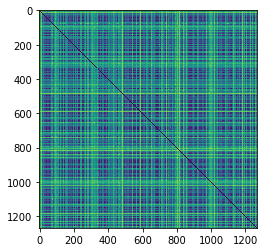

In [10]:
plt.imshow(dist)

474
388
17
841
12
14
12


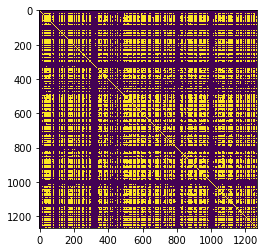

In [11]:
dist_n = (dist-dist.min())/(dist.max()-dist.min())
binary = dist_n < 0.35
plt.imshow(binary)
# se vuoi dare un'occhiata anche a questo...
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import asyn_fluidc
G = nx.from_numpy_array(binary)
giant = max(nx.connected_component_subgraphs(G), key=len)
communities1 = greedy_modularity_communities(giant)
communities2 = asyn_fluidc(giant,4)
for elem in communities1:
    print(len(elem))
for elem in communities2:
    print(len(elem))

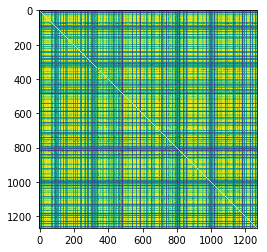

In [12]:
from sklearn.cluster import SpectralClustering

# creation of similarity matrix
# stai attento a questo parametro. se cala viene un unico cluster, se aumenta troppo anche
delta = 7
adj = np.exp(- dist ** 2 / (2. * delta ** 2))
# clustering
spectral = SpectralClustering(3,affinity='precomputed')
labels = spectral.fit_predict(adj)
plt.imshow(adj)

763 252 252


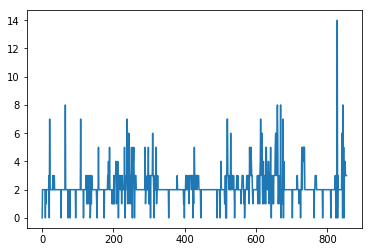

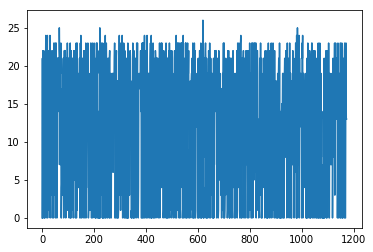

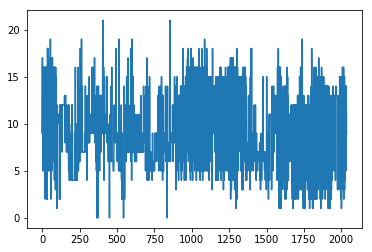

In [13]:
c1 = data[labels==0]
c2 = data[labels==1]
c3 = data[labels==2]


a = np.random.randint(len(c1))
b = np.random.randint(len(c2))
c = np.random.randint(len(c3))


plt.figure()
plt.plot(c1[a][:,4])

plt.figure()
plt.plot(c2[b][:,4])

plt.figure()
plt.plot(c3[c][:,4])

print(len(c1), len(c2), len(c3))

# LSTM part

In [14]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, LSTM,  Dropout
from sklearn.preprocessing import MinMaxScaler
import keras.optimizers

from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [15]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
tot_X = np.zeros((1,50), dtype=int)
tot_y = np.zeros((1,1), dtype=int)

for i in range(len(c1)): # qui metti c2 e c3 per gli altri cluster
    dataset = c1[i]
    dataset = dataset[:,4]
    X, y = split_sequence(dataset, n_steps=50)
    tot_X = np.vstack((tot_X, X))
    y = y.reshape((y.shape[0],1))
    tot_y = np.vstack((tot_y, y))
    
print(tot_X.shape, tot_y.shape)

(1259726, 50) (1259726, 1)


In [17]:
final_dataset = np.hstack((tot_X, tot_y))
del tot_X, tot_y
np.random.seed(1)
perm = np.random.permutation(len(final_dataset))
final_dataset = final_dataset[perm]

In [18]:
# normalize dataset
scaler = MinMaxScaler(feature_range=(-1,1))
final_dataset = scaler.fit_transform(final_dataset)

C:\Users\yurin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
n_train = int(final_dataset.shape[0]*0.7)
n_test = final_dataset.shape[0]-n_train 

X_train = final_dataset[:n_train,:-1]
y_train = final_dataset[:n_train,0]
X_test = final_dataset[n_train:,:-1]
y_test = final_dataset[n_train:,0]

In [20]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
print(X_train.shape, y_train.shape)

(881808, 50, 1) (881808, 1)


In [21]:
# define the model
n_batch = 1024
model = Sequential()
model.add(LSTM(100, input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
es = EarlyStopping(monitor='loss',
                              min_delta=0.01,
                              patience=2,
                              verbose=0, mode='auto')
model.fit(X_train, y_train, epochs=10, batch_size = n_batch,  callbacks=[es], verbose=2)


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 69s - loss: 0.1375
Epoch 2/10
 - 65s - loss: 0.1282
Epoch 3/10
 - 65s - loss: 0.1027
Epoch 4/10
 - 64s - loss: 0.0592
Epoch 5/10
 - 64s - loss: 0.0336
Epoch 6/10
 - 65s - loss: 0.0246
Epoch 7/10
 - 65s - loss: 0.0196
Epoch 8/10
 - 65s - loss: 0.0161
Epoch 9/10
 - 65s - loss: 0.0143


In [23]:
X_test_input = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test_pred = model.predict(X_test_input, verbose=0)
 
# serialize model to JSON
model_json = model.to_json()
with open("modelClusterA.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelClusterA.h5")
print("Saved model to disk")

Saved model to disk


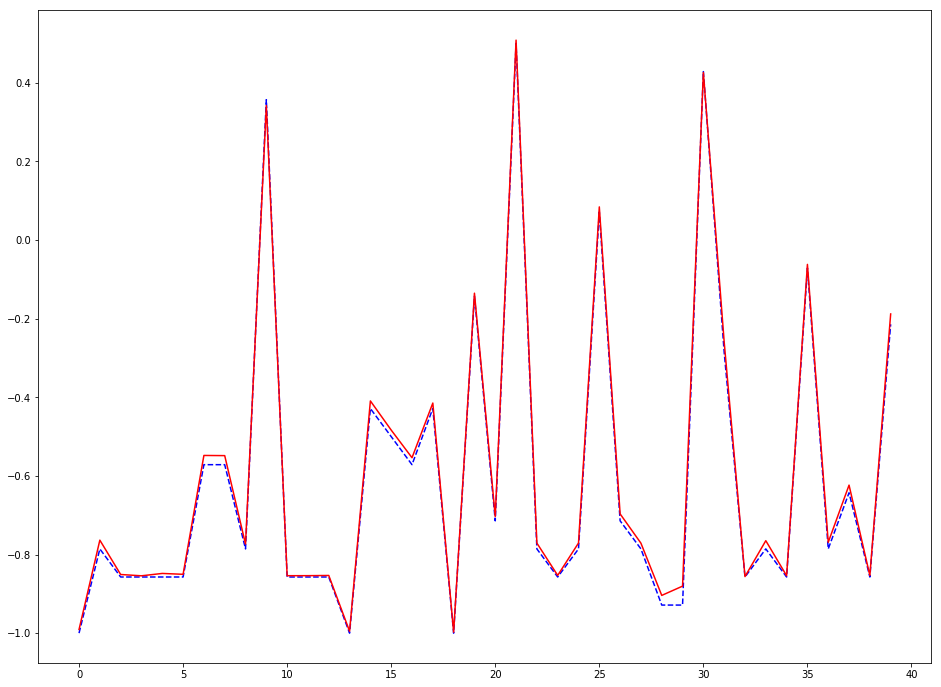

In [24]:
n = 40
time = np.arange(n)
plt.figure(figsize=(16,12))
plt.plot(time, y_test[:n], 'b--')
plt.plot(time, y_test_pred[:n], 'r-')
plt.show()

In [25]:
tot_X = np.zeros((1,50), dtype=int)
tot_y = np.zeros((1,1), dtype=int)

for i in range(len(c2)): # qui metti c2 e c3 per gli altri cluster
    dataset = c2[i]
    dataset = dataset[:,4]
    X, y = split_sequence(dataset, n_steps=50)
    tot_X = np.vstack((tot_X, X))
    y = y.reshape((y.shape[0],1))
    tot_y = np.vstack((tot_y, y))
    
print(tot_X.shape, tot_y.shape)

(476418, 50) (476418, 1)


In [26]:
final_dataset = np.hstack((tot_X, tot_y))
del tot_X, tot_y

perm = np.random.permutation(len(final_dataset))
final_dataset = final_dataset[perm]

In [27]:
# normalize dataset
scaler = MinMaxScaler(feature_range=(-1,1))
final_dataset = scaler.fit_transform(final_dataset)

C:\Users\yurin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
n_train = int(final_dataset.shape[0]*0.7)
n_test = final_dataset.shape[0]-n_train 

X_train = final_dataset[:n_train,:-1]
y_train = final_dataset[:n_train,0]
X_test = final_dataset[n_train:,:-1]
y_test = final_dataset[n_train:,0]

In [29]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
print(X_train.shape, y_train.shape)

(333492, 50, 1) (333492, 1)


In [30]:
# define the model
model = Sequential()
model.add(LSTM(100, input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [31]:
es = EarlyStopping(monitor='loss',
                              min_delta=0.01,
                              patience=2,
                              verbose=0, mode='auto')
model.fit(X_train, y_train, epochs=10, batch_size = n_batch,  callbacks=[es], verbose=2)

Epoch 1/10
 - 25s - loss: 0.4055
Epoch 2/10
 - 25s - loss: 0.4355
Epoch 3/10
 - 25s - loss: 0.3954
Epoch 4/10
 - 25s - loss: 0.2495
Epoch 5/10
 - 25s - loss: 0.1637
Epoch 6/10
 - 25s - loss: 0.1331
Epoch 7/10
 - 24s - loss: 0.1164
Epoch 8/10
 - 24s - loss: 0.0982
Epoch 9/10
 - 24s - loss: 0.0840
Epoch 10/10
 - 24s - loss: 0.0723


In [32]:
X_test_input = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test_pred = model.predict(X_test_input, verbose=0)

 
# serialize model to JSON
model_json = model.to_json()
with open("modelClusterB.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelClusterB.h5")
print("Saved model to disk")

Saved model to disk


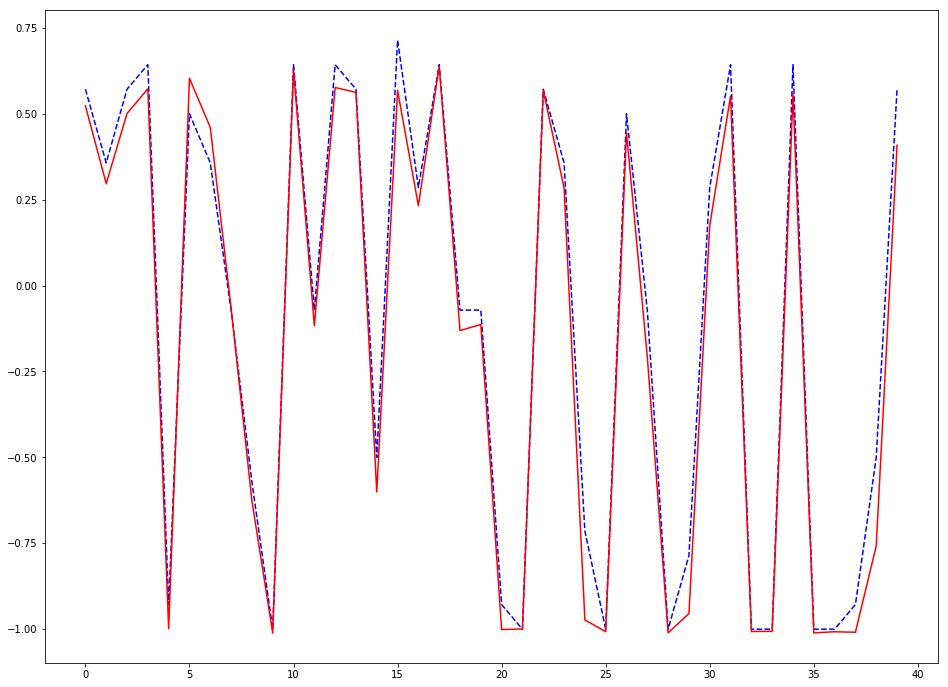

In [33]:
n = 40
time = np.arange(n)
plt.figure(figsize=(16,12))
plt.plot(time, y_test[:n], 'b--')
plt.plot(time, y_test_pred[:n], 'r-')
plt.show()

In [34]:
tot_X = np.zeros((1,50), dtype=int)
tot_y = np.zeros((1,1), dtype=int)

for i in range(len(c3)): # qui metti c2 e c3 per gli altri cluster
    dataset = c3[i]
    dataset = dataset[:,4]
    X, y = split_sequence(dataset, n_steps=50)
    tot_X = np.vstack((tot_X, X))
    y = y.reshape((y.shape[0],1))
    tot_y = np.vstack((tot_y, y))
    
print(tot_X.shape, tot_y.shape)

(969566, 50) (969566, 1)


In [35]:
final_dataset = np.hstack((tot_X, tot_y))
del tot_X, tot_y
perm = np.random.permutation(len(final_dataset))
final_dataset = final_dataset[perm]

In [36]:
# normalize dataset
scaler = MinMaxScaler(feature_range=(-1,1))
final_dataset = scaler.fit_transform(final_dataset)

C:\Users\yurin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [37]:
n_train = int(final_dataset.shape[0]*0.7)
n_test = final_dataset.shape[0]-n_train 

X_train = final_dataset[:n_train,:-1]
y_train = final_dataset[:n_train,0]
X_test = final_dataset[n_train:,:-1]
y_test = final_dataset[n_train:,0]

In [38]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
print(X_train.shape, y_train.shape)

(678696, 50, 1) (678696, 1)


In [39]:
# define the model
model = Sequential()
model.add(LSTM(100, input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [40]:
es = EarlyStopping(monitor='loss',
                              min_delta=0.01,
                              patience=2,
                              verbose=0, mode='auto')
model.fit(X_train, y_train, epochs=10, batch_size = n_batch,  callbacks=[es], verbose=2)

Epoch 1/10
 - 50s - loss: 0.2685
Epoch 2/10
 - 50s - loss: 0.2101
Epoch 3/10
 - 50s - loss: 0.0861
Epoch 4/10
 - 50s - loss: 0.0603
Epoch 5/10
 - 50s - loss: 0.0442
Epoch 6/10
 - 50s - loss: 0.0360
Epoch 7/10
 - 49s - loss: 0.0326
Epoch 8/10
 - 49s - loss: 0.0297
Epoch 9/10
 - 49s - loss: 0.0228


In [41]:
X_test_input = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test_pred = model.predict(X_test_input, verbose=0)

 
# serialize model to JSON
model_json = model.to_json()
with open("modelClusterC.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelClusterC.h5")
print("Saved model to disk")

Saved model to disk


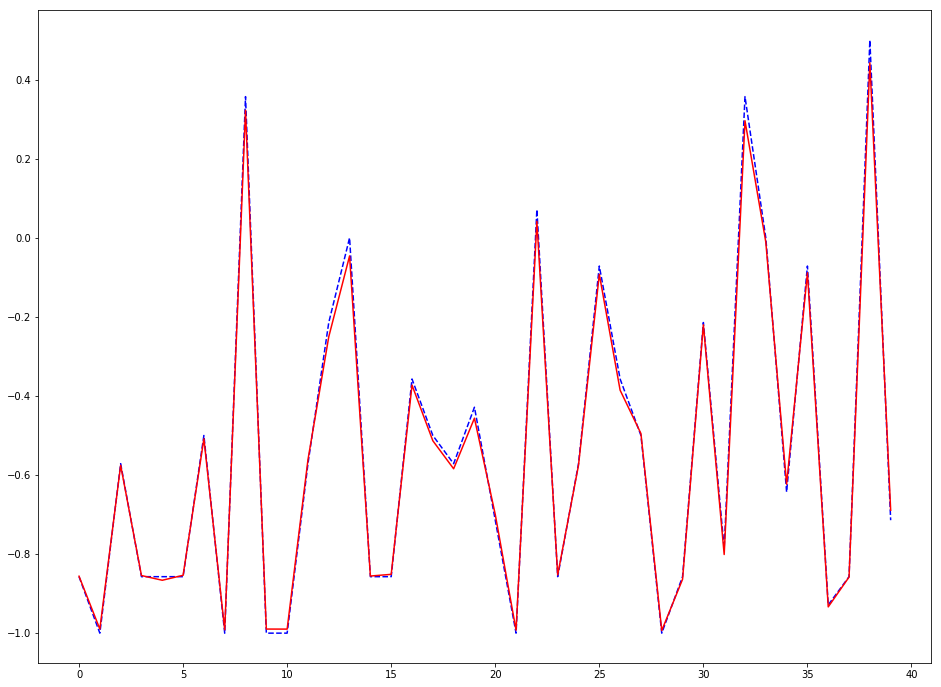

In [42]:
n = 40
time = np.arange(n)
plt.figure(figsize=(16,12))
plt.plot(time, y_test[:n], 'b--')
plt.plot(time, y_test_pred[:n], 'r-')
plt.show()

In [43]:
np.save('labels_B.npy', labels)

In [44]:
type(labels)

numpy.ndarray